In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Personal python module for masks and profiles (available at github.com/cgilhuly/papers/tree/master/common)
import gilphot as gp 

In [2]:
# Loading in images
fitsfile_sub = "/home/cgilhuly/Workspace/MRF/NGC4565/NGC4565_g_final.fits"
image_g_sub, header_g_sub = fits.getdata(fitsfile_sub, header=True)

fitsfile_sub = "/home/cgilhuly/Workspace/MRF/NGC4565/NGC4565_r_final.fits"
image_r_sub, header_r_sub = fits.getdata(fitsfile_sub, header=True)

# Coordinates of image centre
center_sub = (677, 677) 

# Image zeropoints (NOTE: no colour term included for g-band)
zerop_g = 27.24457 
zerop_r = 27.05283 

pix_size = 2.5 # arcsec

# Loading source mask
mask_sub = fits.getdata("/home/cgilhuly/Workspace/Images/NGC4565_starsub_mask2.fits", header=False)

# Masking out already masked regions of each image (union, not intersection)
mask_sub[ image_g_sub == 0.00 ] = 1
mask_sub[ image_r_sub == 0.00 ] = 1

## Surface brightness contrast

In [3]:
from mrf import sbcontrast

# Masking NGC 4565 and areas where source subtraction was not attempted
temp_mask = gp.make_source_mask( image_g_sub, image_r_sub, header_g_sub, "/home/cgilhuly/Workspace/Images/NGC4565_starsub_sbcontrast.txt", "/home/cgilhuly/Workspace/Images/NGC4565_sourcesub_sbcontrast_mask.fits", expand=0 )

dud = sbcontrast.cal_sbcontrast(image_g_sub, temp_mask, 2.5, zerop_g, scale_arcsec=None, sigma=3.0)
dud = sbcontrast.cal_sbcontrast(image_r_sub, temp_mask, 2.5, zerop_r, scale_arcsec=None, sigma=3.0)

    - 3.0-sigma surface brightness limit on 5 arcsec scale is 28.8029 +- 0.0023
    - 3.0-sigma surface brightness limit on 10 arcsec scale is 28.9364 +- 0.0048
    - 3.0-sigma surface brightness limit on 20 arcsec scale is 29.2622 +- 0.0105
    - 3.0-sigma surface brightness limit on 60 arcsec scale is 29.5854 +- 0.0371
    - 3.0-sigma surface brightness limit on 120 arcsec scale is 29.7202 +- 0.0708
    - 3.0-sigma surface brightness limit on 240 arcsec scale is 29.6817 +- 0.1558
    - 3.0-sigma surface brightness limit on 300 arcsec scale is 28.9881 +- 0.2242
    - 3.0-sigma surface brightness limit on 5 arcsec scale is 28.4879 +- 0.0023
    - 3.0-sigma surface brightness limit on 10 arcsec scale is 28.6155 +- 0.0048
    - 3.0-sigma surface brightness limit on 20 arcsec scale is 28.9041 +- 0.0105
    - 3.0-sigma surface brightness limit on 60 arcsec scale is 29.0790 +- 0.0371
    - 3.0-sigma surface brightness limit on 120 arcsec scale is 29.0446 +- 0.0708
    - 3.0-sigma surface br

## Sky/background measurement


Sector 0: radius 350.0 - 400.0 pixels
median sky = -1.342 +/- 0.016
mean sky = -1.278 +/- 0.013
sky RMS = 0.915

Sector 1: radius 400.0 - 450.0 pixels
median sky = -1.294 +/- 0.014
mean sky = -1.243 +/- 0.011
sky RMS = 0.937

Sector 2: radius 450.0 - 500.0 pixels
median sky = -1.028 +/- 0.015
mean sky = -0.957 +/- 0.012
sky RMS = 1.052

Sector 0: radius 350.0 - 400.0 pixels
median sky = -0.845 +/- 0.016
mean sky = -0.777 +/- 0.013
sky RMS = 0.929

Sector 1: radius 400.0 - 450.0 pixels
median sky = -0.930 +/- 0.016
mean sky = -0.875 +/- 0.013
sky RMS = 0.919

Sector 2: radius 450.0 - 500.0 pixels
median sky = -0.698 +/- 0.021
mean sky = -0.643 +/- 0.017
sky RMS = 0.966

Sector 0: radius 350.0 - 400.0 pixels
median sky = -1.576 +/- 0.016
mean sky = -1.530 +/- 0.013
sky RMS = 0.913

Sector 1: radius 400.0 - 450.0 pixels
median sky = -1.490 +/- 0.014
mean sky = -1.421 +/- 0.011
sky RMS = 0.866

Sector 2: radius 450.0 - 500.0 pixels
median sky = -1.606 +/- 0.013
mean sky = -1.555 +/- 0.010

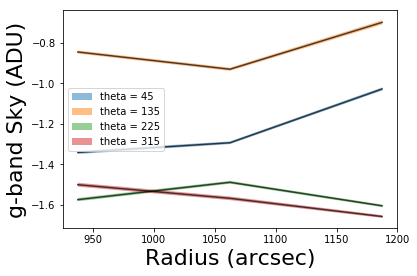

In [4]:
from skimage.morphology import erosion, dilation
from skimage.morphology import disk

mask_sky = dilation(mask_sub,disk(3))

# Loop over sectors and look at radial variation within each sector
theta0 = 0.*np.pi/180.
sectors = 4
delta_theta = 2*np.pi/sectors

for i in range(0, sectors):
    theta1 = theta0 + i*delta_theta
    theta2 = theta1 + delta_theta
    central_theta = (theta1 + theta2)/2. 

    sector_mask = gp.make_sector_mask( image_g_sub, theta1, theta2, center=center_sub )
    new_mask = sector_mask + mask_sky

    skies_r, err_r, noise_r, radii = gp.measure_radial_variation( image_g_sub, initial_mask=new_mask, rad1=350, rad2=500, sectors=3, center=center_sub)
    skies_plus = [x+y/2. for x,y in zip(skies_r, err_r)] # Need to rescale
    skies_minus = [x-y/2. for x,y in zip(skies_r, err_r)]
    plt.plot(np.array(radii)*2.5, np.array(skies_r), 'k-', alpha=0.7)
    plt.fill_between(np.array(radii)*2.5, skies_plus, skies_minus, alpha=0.5, label=f"theta = {(central_theta*180./np.pi):.0f}") 

plt.xlabel("Radius (arcsec)", size=22)
plt.ylabel("g-band Sky (ADU)", size=22)
plt.legend()
plt.show()


Sector 0: radius 300.0 - 350.0 pixels
median sky = -0.796 +/- 0.025
mean sky = -0.760 +/- 0.020
sky RMS = 0.998

Sector 1: radius 350.0 - 400.0 pixels
median sky = -1.400 +/- 0.017
mean sky = -1.366 +/- 0.014
sky RMS = 0.983

Sector 2: radius 400.0 - 450.0 pixels
median sky = -1.342 +/- 0.015
mean sky = -1.294 +/- 0.012
sky RMS = 1.026

Sector 3: radius 450.0 - 500.0 pixels
median sky = -1.042 +/- 0.017
mean sky = -0.948 +/- 0.013
sky RMS = 1.133

Sector 4: radius 500.0 - 550.0 pixels
median sky = -1.544 +/- 0.016
mean sky = -1.480 +/- 0.013
sky RMS = 0.994

Sector 5: radius 550.0 - 600.0 pixels
median sky = -1.331 +/- 0.015
mean sky = -1.276 +/- 0.012
sky RMS = 0.991

Sector 6: radius 600.0 - 650.0 pixels
median sky = -1.534 +/- 0.017
mean sky = -1.466 +/- 0.014
sky RMS = 0.966

Sector 7: radius 650.0 - 700.0 pixels
median sky = -1.449 +/- 0.022
mean sky = -1.434 +/- 0.018
sky RMS = 1.009

Sector 8: radius 700.0 - 750.0 pixels
median sky = -1.517 +/- 0.024
mean sky = -1.430 +/- 0.019

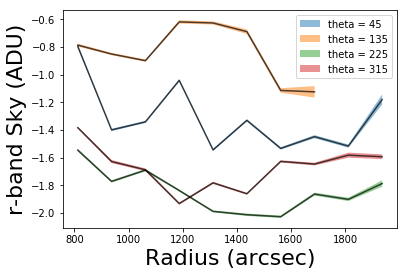

In [5]:
# Loop over sectors and look at radial variation within each sector
theta0 = 0.*np.pi/180.
sectors = 4
delta_theta = 2*np.pi/sectors

for i in range(0, sectors):
    theta1 = theta0 + i*delta_theta
    theta2 = theta1 + delta_theta
    central_theta = (theta1 + theta2)/2. 

    sector_mask = gp.make_sector_mask( image_r_sub, theta1, theta2, center=center_sub )
    new_mask = sector_mask + mask_sky

    skies_r, err_r, noise_r, radii = gp.measure_radial_variation( image_r_sub, initial_mask=new_mask, rad1=300, rad2=800, sectors=10, center=center_sub)
    skies_plus = [x+y/2. for x,y in zip(skies_r, err_r)] # Need to rescale
    skies_minus = [x-y/2. for x,y in zip(skies_r, err_r)]
    plt.plot(np.array(radii)*2.5, np.array(skies_r), 'k-', alpha=0.7)
    plt.fill_between(np.array(radii)*2.5, skies_plus, skies_minus, alpha=0.5, label=f"theta = {(central_theta*180./np.pi):.0f}") 

plt.xlabel("Radius (arcsec)", size=22)
plt.ylabel("r-band Sky (ADU)", size=22)
plt.legend()
plt.show()

In [6]:
# Sky values and errors for each image quadrant
sky_g_SE_sub = -0.932
sky_g_SE_err = 0.016  
sky_g_SE_sys = 0.932 - 0.691  # Based on greatest difference between adjacent radial bin

sky_g_NW_sub = -1.570 
sky_g_NW_err = 0.018
sky_g_NW_sys = 1.659 - 1.570

sky_r_SE_sub = -0.889
sky_r_SE_err =  0.017 
sky_r_SE_sys = 0.889 - 0.618

sky_r_NW_sub = -1.690 
sky_r_NW_err =  0.019
sky_r_NW_sys = 1.690 - 1.868


## Calculating surface brightness and colour profiles

In [7]:
# Calculating NW profiles

rad_profile_g_sub, r_g_sub, err_g_sub = gp.radial_profile_slice(image_g_sub, mask_sub, center_sub, PA=136., width=5, bin_edges=[180,250,350,450], bin_widths=[3,5,10,50,100])
rad_profile_r_sub, r_r_sub, err_r_sub = gp.radial_profile_slice(image_r_sub, mask_sub, center_sub, PA=136., width=5, bin_edges=[180,250,350,450], bin_widths=[3,5,10,50,100])

mag_g_sub = zerop_g - 2.5*np.log10(np.array(rad_profile_g_sub) - sky_g_NW_sub) + 5*np.log10(pix_size)
mag_r_sub = zerop_r - 2.5*np.log10(np.array(rad_profile_r_sub) - sky_r_NW_sub) + 5*np.log10(pix_size)

# Upper and lower SB error limits (in mag/arcsec^2)
mag_g_p_sub, mag_g_m_sub = gp.calc_profile_error( rad_profile_g_sub, err_g_sub, sky_g_NW_sub, sky_g_NW_err, zerop_g )
mag_r_p_sub, mag_r_m_sub = gp.calc_profile_error( rad_profile_r_sub, err_r_sub, sky_r_NW_sub, sky_r_NW_err, zerop_r )

# Including systematic uncertainty in sky
mag_g_ps_sub, mag_g_ms_sub = gp.calc_profile_error( rad_profile_g_sub, err_g_sub, sky_g_NW_sub, sky_g_NW_err, zerop_g, sky_g_NW_sys )
mag_r_ps_sub, mag_r_ms_sub = gp.calc_profile_error( rad_profile_r_sub, err_r_sub, sky_r_NW_sub, sky_r_NW_err, zerop_r, sky_r_NW_sys )

# Colour and error (without and with sys. uncertainty in sky)
gmr_sub = np.array(mag_g_sub) - np.array(mag_r_sub)
gmr_err_sub = gp.calc_colour_error( rad_profile_g_sub, err_g_sub, rad_profile_r_sub, err_r_sub, sky_g_NW_sub, sky_r_NW_sub, sky_g_NW_err, sky_r_NW_err )
gmr_err_sub_sys = gp.calc_colour_error( rad_profile_g_sub, err_g_sub, rad_profile_r_sub, err_r_sub, sky_g_NW_sub, sky_r_NW_sub, sky_g_NW_err, sky_r_NW_err, sky_g_NW_sys, sky_r_NW_sys )

# Packaging up error bars for convenient plotting
g_err_NW = [mag_g_sub - mag_g_p_sub, mag_g_m_sub - mag_g_sub]
r_err_NW = [mag_r_sub - mag_r_p_sub, mag_r_m_sub - mag_r_sub]

gmr_p_NW = gmr_sub + gmr_err_sub_sys
gmr_m_NW = gmr_sub - gmr_err_sub_sys

In [8]:
# Calculating SE profiles

rad_profile_g_SE_sub, r_g_SE_sub, err_g_SE_sub = gp.radial_profile_slice(image_g_sub, mask_sub, center_sub, PA=316., width=5, bin_edges=[180,250,350,800], bin_widths=[3,5,10,50,100])
rad_profile_r_SE_sub, r_r_SE_sub, err_r_SE_sub = gp.radial_profile_slice(image_r_sub, mask_sub, center_sub, PA=316., width=5, bin_edges=[180,250,350,800], bin_widths=[3,5,10,50,100])

mag_g_SE_sub = zerop_g - 2.5*np.log10(np.array(rad_profile_g_SE_sub) - sky_g_SE_sub) + 5*np.log10(pix_size)
mag_r_SE_sub = zerop_r - 2.5*np.log10(np.array(rad_profile_r_SE_sub) - sky_r_SE_sub) + 5*np.log10(pix_size)

# Upper and lower SB error limits (in mag/arcsec^2)
mag_g_p_SE_sub, mag_g_m_SE_sub = gp.calc_profile_error( rad_profile_g_SE_sub, err_g_SE_sub, sky_g_SE_sub, sky_g_SE_err, zerop_g )
mag_r_p_SE_sub, mag_r_m_SE_sub = gp.calc_profile_error( rad_profile_r_SE_sub, err_r_SE_sub, sky_r_SE_sub, sky_r_SE_err, zerop_r )

# Including systematic uncertainty in sky
mag_g_ps_SE_sub, mag_g_ms_SE_sub = gp.calc_profile_error( rad_profile_g_SE_sub, err_g_SE_sub, sky_g_SE_sub, sky_g_SE_err, zerop_g, sky_g_SE_sys )
mag_r_ps_SE_sub, mag_r_ms_SE_sub = gp.calc_profile_error( rad_profile_r_SE_sub, err_r_SE_sub, sky_r_SE_sub, sky_r_SE_err, zerop_r, sky_r_SE_sys )

# Colour and error (without and with sys. uncertainty in sky)
gmr_SE_sub = np.array(mag_g_SE_sub) - np.array(mag_r_SE_sub)
gmr_err_SE_sub = gp.calc_colour_error( rad_profile_g_SE_sub, err_g_SE_sub, rad_profile_r_SE_sub, err_r_SE_sub, sky_g_SE_sub, sky_r_SE_sub, sky_g_SE_err, sky_r_SE_err )
gmr_err_SE_sub_sys = gp.calc_colour_error( rad_profile_g_SE_sub, err_g_SE_sub, rad_profile_r_SE_sub, err_r_SE_sub, sky_g_SE_sub, sky_r_SE_sub, sky_g_SE_err, sky_r_SE_err, sky_g_SE_sys, sky_r_SE_sys )

# Packaging up error bars for convenient plotting
g_err_SE = [mag_g_SE_sub - mag_g_p_SE_sub, mag_g_m_SE_sub - mag_g_SE_sub]
r_err_SE = [mag_r_SE_sub - mag_r_p_SE_sub, mag_r_m_SE_sub - mag_r_SE_sub]

gmr_p_SE = gmr_SE_sub + gmr_err_SE_sub_sys
gmr_m_SE = gmr_SE_sub - gmr_err_SE_sub_sys



## Applying extinction corrections (very small due to Galactic cirrus-avoiding selection criteria)

In [9]:
# Galactic extinction (Schlafly et al. 2011; accessed via NED)
extinct_g = 0.051
extinct_r = 0.035

# NW
mag_g_sub = np.array(mag_g_sub) - extinct_g
mag_r_sub = np.array(mag_r_sub) - extinct_r

gmr_sub = np.array(gmr_sub) - extinct_g + extinct_r

mag_g_ps_sub = np.array(mag_g_ps_sub) - extinct_g
mag_g_ms_sub = np.array(mag_g_ms_sub) - extinct_g
mag_r_ps_sub = np.array(mag_r_ps_sub) - extinct_r
mag_r_ms_sub = np.array(mag_r_ms_sub) - extinct_r


# SE
mag_g_SE_sub = np.array(mag_g_SE_sub) - extinct_g
mag_r_SE_sub = np.array(mag_r_SE_sub) - extinct_r

gmr_SE_sub = np.array(gmr_SE_sub) - extinct_g + extinct_r

mag_g_ps_SE_sub = np.array(mag_g_ps_SE_sub) - extinct_g
mag_g_ms_SE_sub = np.array(mag_g_ms_SE_sub) - extinct_g
mag_r_ps_SE_sub = np.array(mag_r_ps_SE_sub) - extinct_r
mag_r_ms_SE_sub = np.array(mag_r_ms_SE_sub) - extinct_r


## Figure with SE and NW profiles "back to back"

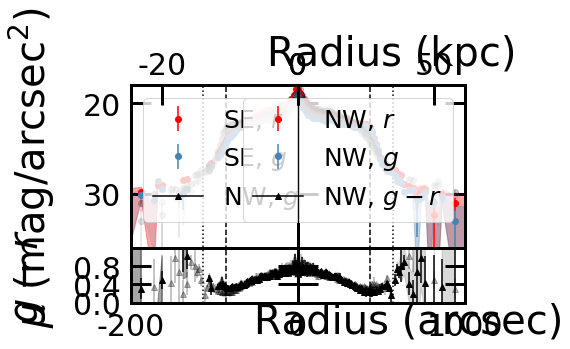

In [10]:
# Making figure with 4 subpanels
fig, ax = plt.subplots(ncols=2, nrows=2)
gs1 = gridspec.GridSpec(2,2,wspace=0,hspace=0, height_ratios = [3,1])

################################################################################
# SE surface brightness profiles (top left panel)
ax0 = plt.subplot(gs1[0])

plt.errorbar( np.array(r_r_SE_sub)*pix_size, mag_r_SE_sub, yerr=r_err_SE, label="SE, $r$", fmt='o', color='r')
plt.errorbar( np.array(r_g_SE_sub)*pix_size, mag_g_SE_sub, yerr=g_err_SE, label="SE, $g$", fmt='o', color='steelblue')

ax0.errorbar([0], [0], label="NW, $g-r$", color='k', marker='^') # Dummy for legend

# Eror envelopes including systematic uncertainty in sky
plt.fill_between(np.array(r_r_SE_sub)*pix_size,mag_r_ps_SE_sub, mag_r_ms_SE_sub, alpha=0.35, color="r")
plt.fill_between(np.array(r_g_SE_sub)*pix_size,mag_g_ps_SE_sub, mag_g_ms_SE_sub, alpha=0.15, color="steelblue")

# NW profiles in faint grey for reference
plt.errorbar( np.array(r_r_sub)*pix_size, mag_r_sub, yerr=r_err_NW, color='black', fmt='o', alpha=0.2)
plt.errorbar( np.array(r_g_sub)*pix_size, mag_g_sub, yerr=g_err_NW, color='dimgrey', fmt='o', alpha=0.2)

leg = plt.legend(loc=2, prop={'size': 25})  

ax0.set_xticklabels([])
ax0.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=40, labelpad=25)
ax0.invert_yaxis()


################################################################################
# SE g-r profile (lower left panel)
ax2 = plt.subplot(gs1[2])

ax2.errorbar( np.array(r_r_SE_sub)*pix_size, gmr_SE_sub, yerr = gmr_err_SE_sub, label="$g-r$", color='k', fmt='o', marker='^')
plt.fill_between(np.array(r_r_SE_sub)*pix_size, gmr_m_SE, gmr_p_SE, alpha=0.35, color="k")

# NW profile in faint grey for reference
ax2.errorbar( np.array(r_r_sub)*pix_size, gmr_sub, yerr = gmr_err_sub, color='black', fmt='o', marker='^', alpha=0.3)

ax2.set_ylabel(r"$g-r$", size=40, labelpad=25)


################################################################################
# NW surface brightness profiles (top right panel)
ax1 = plt.subplot(gs1[1])

plt.errorbar( np.array(r_r_sub)*pix_size, mag_r_sub, yerr=r_err_NW, label="NW, $r$", fmt='o', color='red')
plt.errorbar( np.array(r_g_sub)*pix_size, mag_g_sub, yerr=g_err_NW, label="NW, $g$", fmt='o', color='steelblue')

ax1.errorbar([0], [0], label="NW, $g-r$", color='k', marker='^') # Dummy for legend

# Error envelopes including systematic uncertainty in sky
plt.fill_between(np.array(r_r_sub)*pix_size,mag_r_ps_sub, mag_r_ms_sub, alpha=0.35, color="red")
plt.fill_between(np.array(r_g_sub)*pix_size,mag_g_ps_sub, mag_g_ms_sub, alpha=0.35, color="steelblue")

# SE profiles in faint grey for reference
plt.errorbar( np.array(r_r_SE_sub)*pix_size, mag_r_SE_sub, yerr=r_err_SE, color='black', fmt='o', alpha=0.2)
plt.errorbar( np.array(r_g_SE_sub)*pix_size, mag_g_SE_sub, yerr=g_err_SE, color='dimgrey', fmt='o', alpha=0.2)

leg = plt.legend(loc=1, prop={'size': 25})
    
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.invert_yaxis()


################################################################################
# NW g-r profiles (bottom right panel)
ax3 = plt.subplot(gs1[3])

ax3.errorbar( np.array(r_r_sub)*pix_size, gmr_sub, yerr = gmr_err_sub, label="g-r", color='k', fmt='o', marker='^')
plt.fill_between(np.array(r_r_sub)*pix_size, gmr_m_NW, gmr_p_NW, alpha=0.15, color="k")

# SE profile in faint grey for reference
ax3.errorbar( np.array(r_r_SE_sub)*pix_size, gmr_SE_sub, yerr = gmr_err_SE_sub, color='black', fmt='o', marker='^', alpha=0.3)

ax3.set_yticklabels([])


################################################################################
# Common formatting for all subplots
for axis in [ax0, ax1, ax2, ax3]: 
    
    # Tick parameters
    axis.tick_params(axis='both',which='major',direction='in')
    axis.tick_params(labelsize=30)
    axis.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
    axis.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
     
    # Tweaking line weights
    axis.spines['bottom'].set_linewidth(3)
    axis.spines['top'].set_linewidth(3)
    axis.spines['left'].set_linewidth(3)
    axis.spines['right'].set_linewidth(3)
    
    # Adding lines for NW truncation radius and fan radius
    axis.plot([430, 430],[0,36], 'k--')
    axis.plot([570, 570],[0,36], 'k:')
    
# Secondary x axis for physical length scales (SE side)
ax02 = ax0.twiny()
ax02.set_xlim(61.48,0)  # 1000 arcsec at a distance of 12.7 Mpc
ax02.tick_params(labelsize=30)
ax02.xaxis.set_tick_params(which='major',size=20,width=3,pad=5,top=True,right=True, direction="in")

# Secondary x axis (NW side)
ax12 = ax1.twiny()
ax12.set_xlim(0,61.48)  # 1000 arcsec at a distance of 12.7 Mpc
ax12.tick_params(labelsize=30)
ax12.xaxis.set_tick_params(which='major',size=20,width=3,pad=5,top=True,right=True, direction="in")

# Fixing plot limits
ax1.set_xlim(0, 1000)
ax1.set_ylim(36, 18)
ax3.set_xlim(0, 1000)
ax3.set_ylim(0, 1.2)
ax3.set_yticks([0,0.4, 0.8, 1.2])

ax0.set_xlim(1000,0)
ax0.set_ylim(36, 18)
ax2.set_xlim(1000, 0)
ax2.set_ylim(0, 1.2)
ax2.set_yticks([0,0.4, 0.8, 1.2])
ax2.set_yticklabels(["0.0","0.4", "0.8", ""])

# Using negative radius labels for reversed SE side of figure
ax2.set_xticklabels(["", "-200", "-400", "-600", "-800", "-1000"])
ax02.set_xticklabels(["0", "-20", "-40", "-60"])

# Shared axis labels
fig.text(0.41, 0.02, "Radius (arcsec)", size=40)
fig.text(0.44, 0.95, "Radius (kpc)", size=40)

##fig.set_size_inches(22, 14)
##plt.savefig("/home/cgilhuly/Documents/NGC4565_slice_profiles.pdf")
plt.show()

## Comparison with 2D models

In [11]:
# Load in model images
fitsfile_model = "/home/cgilhuly/Workspace/Imfit/NGC4565/NGC4565_model_r_PSF_dustlane.fits"
image_r_model_PSF = fits.getdata(fitsfile_model, header=False)

fitsfile_model = "/home/cgilhuly/Workspace/Imfit/NGC4565/NGC4565_model_r_noPSF_dustlane.fits"
image_r_model_noPSF = fits.getdata(fitsfile_model, header=False)

fitsfile_model = "/home/cgilhuly/Workspace/Imfit/NGC4565/NGC4565_model_g_PSF_dustlane.fits"
image_g_model_PSF = fits.getdata(fitsfile_model, header=False)

fitsfile_model = "/home/cgilhuly/Workspace/Imfit/NGC4565/NGC4565_model_g_noPSF_dustlane.fits"
image_g_model_noPSF = fits.getdata(fitsfile_model, header=False)

mask_model = np.zeros( np.shape(image_r_model_PSF) )

In [12]:
rad_profile_model_PSF, r_model_PSF, err_model_PSF = gp.radial_profile_slice(image_r_model_PSF, mask_model, center_sub, PA=136., width=5, bin_edges=[180,250,350,450], bin_widths=[3,5,10,50,100])
rad_profile_model_noPSF, r_model_noPSF, err_model_noPSF = gp.radial_profile_slice(image_r_model_noPSF, mask_model, center_sub, PA=136., width=5, bin_edges=[180,250,350,450], bin_widths=[3,5,10,50,100])

mag_model_PSF = zerop_r - 2.5*np.log10(np.array(rad_profile_model_PSF) - 0.0) + 5*np.log10(pix_size) - extinct_r
mag_model_noPSF = zerop_r - 2.5*np.log10(np.array(rad_profile_model_noPSF) - 0.0) + 5*np.log10(pix_size) - extinct_r

rad_profile_model_g_PSF, r_model_g_PSF, err_model_g_PSF = gp.radial_profile_slice(image_g_model_PSF, mask_model, center_sub, PA=136., width=5, bin_edges=[180,250,350,450], bin_widths=[3,5,10,50,100])
rad_profile_model_g_noPSF, r_model_g_noPSF, err_model_g_noPSF = gp.radial_profile_slice(image_g_model_noPSF, mask_model, center_sub, PA=136., width=5, bin_edges=[180,250,350,450], bin_widths=[3,5,10,50,100])

mag_model_g_PSF = zerop_g - 2.5*np.log10(np.array(rad_profile_model_g_PSF) - 0.0) + 5*np.log10(pix_size) - extinct_g
mag_model_g_noPSF = zerop_g - 2.5*np.log10(np.array(rad_profile_model_g_noPSF) - 0.0) + 5*np.log10(pix_size) - extinct_g


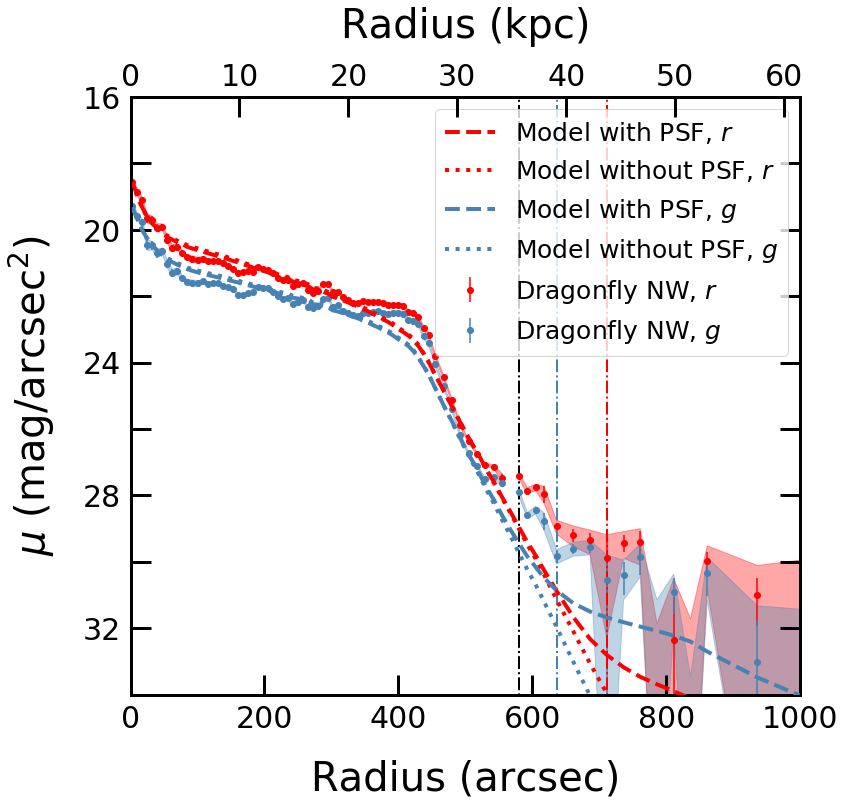

In [13]:
fig, ax = plt.subplots()

plt.errorbar( np.array(r_r_sub)*pix_size, mag_r_sub, yerr=r_err_NW, label="Dragonfly NW, $r$", fmt='o', color='r')

# Error envelopes including systematic uncertainty in sky
plt.fill_between(np.array(r_r_sub)*pix_size,mag_r_ps_sub, mag_r_ms_sub, alpha=0.35, color="r")

plt.plot( np.array(r_model_PSF)*pix_size, mag_model_PSF, 'r--', label="Model with PSF, $r$",  zorder=10, lw=4)
plt.plot( np.array(r_model_noPSF)*pix_size, mag_model_noPSF, 'r:', label="Model without PSF, $r$",  zorder=8, lw=4)

plt.errorbar( np.array(r_g_sub)*pix_size, mag_g_sub, yerr=g_err_NW, label="Dragonfly NW, $g$", fmt='o', color='steelblue')
plt.fill_between(np.array(r_g_sub)*pix_size,mag_g_ps_sub, mag_g_ms_sub, alpha=0.35, color="steelblue")

plt.plot( np.array(r_model_g_PSF)*pix_size, mag_model_g_PSF, '--', c="steelblue", label="Model with PSF, $g$",  zorder=10, lw=4)
plt.plot( np.array(r_model_g_noPSF)*pix_size, mag_model_g_noPSF, ':', c="steelblue", label="Model without PSF, $g$",  zorder=8, lw=4)

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=30, labelpad=25)
ax.set_xlabel(r"Radius (arcsec)", size=30, labelpad=25)

leg = plt.legend(loc=1, prop={'size': 25})

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=40, labelpad=25)
ax.set_xlabel(r"Radius (arcsec)", size=40, labelpad=25)
ax.tick_params(labelsize=30)
ax.invert_yaxis()

# Formatting ticks and plot edges 
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)

ax.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,61.48)  # 1800 arcsec at a distance of 12.7 Mpc
ax3.set_xlabel(r"Radius (kpc)", size=40, labelpad=25)
ax3.tick_params(labelsize=30)
ax3.xaxis.set_tick_params(which='major',size=20,width=3,pad=5,top=True,right=True, direction="in")

ax.set_xlim(0,1000)
ax.set_ylim(34, 16)

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", ""])

ax.plot([580,580],[0,36], 'k-.', lw=2)
ax.plot([636.25, 636.25],[0,36], '-.', c="steelblue", lw=2)
ax.plot([711.25, 711.25],[0,36], 'r-.', lw=2)


fig.set_size_inches(12,11)
##plt.savefig("/home/cgilhuly/Documents/NGC4565_major-axis_PSFtest_new.pdf")

plt.show()

In [14]:
# Measurements of model profiles

# For both bands, when does PSF profile (flux) = 2x noPSF profile (flux)? (radius and SB)
for i in range(0,len(rad_profile_model_PSF)):
    
    if rad_profile_model_PSF[i] >= 2.0 * rad_profile_model_noPSF[i]:
        print( f"Major axis: r-band scattered light dominates over disc at {r_model_PSF[i]*pix_size} arcsec (SB = {mag_model_PSF[i]}) ")
        break
    
for i in range(0,len(rad_profile_model_g_PSF)):
    
    if rad_profile_model_g_PSF[i] >= 2.0 * rad_profile_model_g_noPSF[i]:
        print( f"Major axis: g-band scattered light dominates over disc at {r_model_g_PSF[i]*pix_size} arcsec (SB = {mag_model_g_PSF[i]}) ")
        break
        
# At position of fan (570 arcsec) and radii where PSF profile >= 2x noPSF profile:
# How does (PSF - noPSF) compare to observed profile? Estimate fraction of scattered light contribution

frac_scattered_r0 = ( rad_profile_model_PSF[70] - rad_profile_model_noPSF[70] ) / ( rad_profile_r_sub[70] - sky_r_NW_sub )
frac_scattered_r1 = ( rad_profile_model_PSF[74] - rad_profile_model_noPSF[74] ) / ( rad_profile_r_sub[74] - sky_r_NW_sub )
frac_scattered_r2 = ( rad_profile_model_PSF[77] - rad_profile_model_noPSF[77] ) / ( rad_profile_r_sub[77] - sky_r_NW_sub )

frac_scattered_g0 = ( rad_profile_model_g_PSF[70] - rad_profile_model_g_noPSF[70] ) / ( rad_profile_g_sub[70] - sky_g_NW_sub )
frac_scattered_g1 = ( rad_profile_model_g_PSF[74] - rad_profile_model_g_noPSF[74] ) / ( rad_profile_g_sub[74] - sky_g_NW_sub )
frac_scattered_g2 = ( rad_profile_model_g_PSF[77] - rad_profile_model_g_noPSF[77] ) / ( rad_profile_g_sub[77] - sky_g_NW_sub )

print()
print( f"Estimated fraction of scattered light at {r_r_sub[70]*2.5} arcsec:" )
print( f"r: {frac_scattered_r0}" )
print( f"g: {frac_scattered_g0}" )

print()
print( f"Estimated fraction of scattered light at {r_r_sub[74]*2.5} arcsec:" )
print( f"r: {frac_scattered_r1}" )
print( f"g: {frac_scattered_g1}" )

print()
print( f"Estimated fraction of scattered light at {r_r_sub[77]*2.5} arcsec:" )
print( f"r: {frac_scattered_r2}" )
print( f"g: {frac_scattered_g2}" )

Major axis: r-band scattered light dominates over disc at 711.25 arcsec (SB = 32.8000103693722) 
Major axis: g-band scattered light dominates over disc at 636.25 arcsec (SB = 30.858854454598095) 

Estimated fraction of scattered light at 580.0 arcsec:
r: 0.010971095565057133
g: 0.05682097223813651

Estimated fraction of scattered light at 636.25 arcsec:
r: 0.03583359411354441
g: 0.24551415214157418

Estimated fraction of scattered light at 711.25 arcsec:
r: 0.044274113382393045
g: 0.34135338351445554


## Comparison with literature profiles

In [15]:
wu_data = open("/home/cgilhuly/Workspace/Profiles/NGC4565_wu02_i.prof", "r")
SB_wu = []
rad_wu = []
err_upp_wu = []
err_low_wu = []

for line in wu_data:
    
    if line.startswith( "#" ):
        continue
        
    SB_wu.append( float( line.split()[3] ) )
    rad_wu.append( float( line.split()[1] ) )
    err_upp_wu.append( float( line.split()[4] ) )
    err_low_wu.append( float( line.split()[5] ) )
    
wu_data.close()

err_wu = [err_upp_wu, err_low_wu]


nj_data = open("/home/cgilhuly/Workspace/Profiles/NGC4565_V_naeslund96.dat", "r")
rad_nj = []
SB_V_nj = []
SB_V_SE_nj = []
err_upp_nj = []
err_low_nj = []

for line in nj_data:
    
    SB_V_nj.append( float( line.split()[2] ) )
    SB_V_SE_nj.append( float( line.split()[5] ) )
    rad_nj.append( float( line.split()[1] ) )
    err_upp_nj.append( SB_V_nj[-1] - float( line.split()[3] )  )
    err_low_nj.append( float( line.split()[4] ) - SB_V_nj[-1] )  
    
nj_data.close()

err_nj_10 = [err_upp_nj[::10], err_low_nj[::10]]
err_nj = [err_upp_nj, err_low_nj]


ml_data = open("/home/cgilhuly/Workspace/Profiles/NGC4565-MidPlaneRProf_gri_martinezlombilla19.txt", "r")

line = ml_data.readline()
rad_ml = [float(x) for x in line.split()]

line = ml_data.readline()
SB_gri_ml = [float(x) for x in line.split()]

line = ml_data.readline()
err_upp_ml = [float(x) for x in line.split()]

line = ml_data.readline()
err_low_ml = [float(x) for x in line.split()]
    
ml_data.close()

err_ml = [err_upp_ml, err_low_ml]

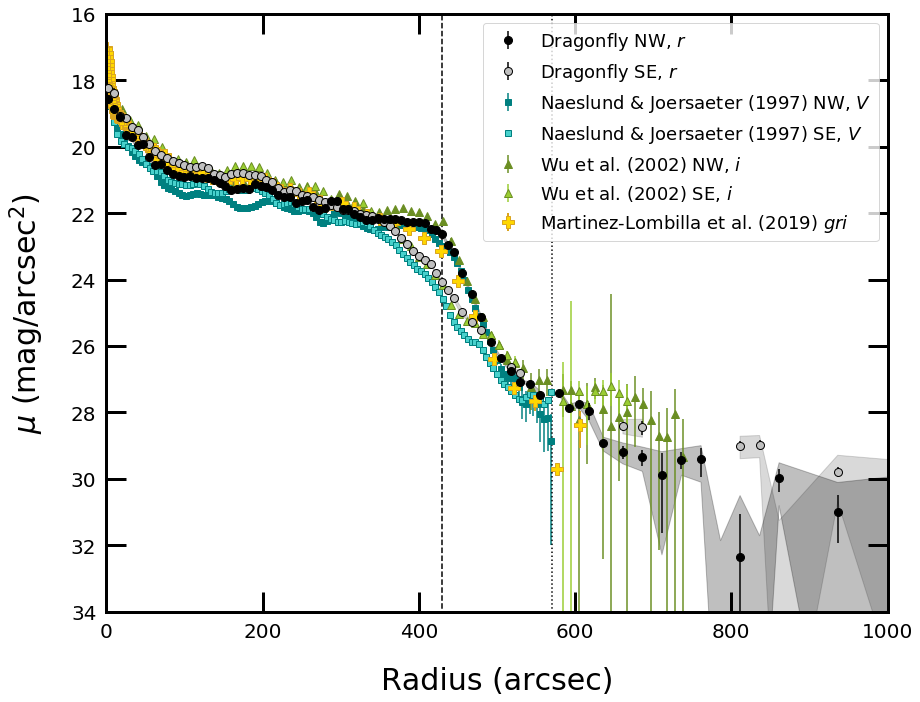

In [16]:
fig, ax = plt.subplots()

plt.errorbar( np.array(r_r_sub)*pix_size, mag_r_sub, yerr=r_err_NW, label="Dragonfly NW, $r$", fmt='o', color='k', markersize=8, zorder=10)
plt.errorbar( np.array(r_r_SE_sub)*pix_size, mag_r_SE_sub, yerr=r_err_SE, label="Dragonfly SE, $r$", fmt='o', color='silver', markeredgecolor="k", ecolor="k", markersize=8, zorder=8)

plt.errorbar( np.array(rad_nj)[::10]*20.673, SB_V_nj[::10], yerr=err_nj_10, fmt="s", markersize=6, color="teal", label="Naeslund & Joersaeter (1997) NW, $V$" )
plt.errorbar( np.array(rad_nj)[::10]*20.673, SB_V_SE_nj[::10], fmt="s", markersize=6, color="mediumturquoise",  markeredgecolor="teal",  label="Naeslund & Joersaeter (1997) SE, $V$" )

plt.errorbar( rad_wu, SB_wu, yerr=err_wu, color="olivedrab", label="Wu et al. (2002) NW, $i$", fmt='^', markersize=8 )
plt.errorbar( np.array(rad_wu)*-1., SB_wu, yerr=err_wu, color="yellowgreen", markeredgecolor="olivedrab", label="Wu et al. (2002) SE, $i$", fmt='^', markersize=8 )

plt.errorbar( rad_ml, SB_gri_ml, yerr=err_ml, fmt="P", lw=2, markersize=12, color="gold", markeredgecolor="goldenrod", ecolor="goldenrod", label="Martinez-Lombilla et al. (2019) $gri$" )

plt.fill_between(np.array(r_r_sub)*pix_size,mag_r_ps_sub, mag_r_ms_sub, alpha=0.25, color="k")
plt.fill_between(np.array(r_r_SE_sub)*pix_size,mag_r_ps_SE_sub, mag_r_ms_SE_sub, alpha=0.15, color="k")

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=30, labelpad=25)
ax.set_xlabel(r"Radius (arcsec)", size=30, labelpad=25)

leg = plt.legend(loc=1, prop={'size': 18})

# Tweaking appearance of plot
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)

ax.tick_params(labelsize=20)
ax.xaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,width=3,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

ax.set_xlim(0,1000)
ax.set_ylim(34, 16)

ax.plot([430, 430],[0,36], 'k--')
ax.plot([570, 570],[0,36], 'k:')

fig.set_size_inches(14, 11)
##plt.savefig("/home/cgilhuly/Documents/NGC4565_comparison.pdf")
plt.show()